In [1]:
!pip install ptflops decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Imports
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from timm import create_model
from decord import VideoReader, cpu
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import time

In [3]:
# --- Configuration ---
VIDEO_DIR = '/content/drive/MyDrive/ARID Train/ARIDv1.5/Videos'
OUTPUT_DIR = '/content/drive/MyDrive/ARID Train/ARIDv1.5/Splits'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 16
NUM_EPOCHS = 40
PATIENCE = 10
TOTAL_CLIPS = 6207
NUM_CLASSES = 11
SEQ_LEN = 3
INPUT_SIZE = 224

In [4]:
# --- Video Dataset ---
class VideoDataset(Dataset):
    def __init__(self, csv_file, video_dir, transform=None, seq_len=SEQ_LEN):
        self.data = pd.read_csv(csv_file)
        self.video_dir = video_dir
        self.transform = transform
        self.seq_len = seq_len
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.data.iloc[idx]['video_name'])
        label = self.label_to_idx[self.data.iloc[idx]['label']]
        try:
            vr = VideoReader(video_path, ctx=cpu(0))
            total_frames = len(vr)
            if total_frames < self.seq_len:
                indices = np.arange(total_frames)
                indices = np.pad(indices, (0, self.seq_len - total_frames), mode='edge')
            else:
                indices = np.linspace(0, total_frames - 1, self.seq_len, dtype=int)
            frames = vr.get_batch(indices).asnumpy()
            frames = torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0
            brightness = frames.mean().item()
            if self.transform:
                frames = torch.stack([self.transform(frame) for frame in frames])
            frames = frames.permute(1, 0, 2, 3)
            return frames, label, brightness
        except Exception as e:
            print(f"Error loading {video_path}: {e}")
            return torch.zeros(3, self.seq_len, 224, 224), label, 0.0

In [5]:
# --- TSM Module ---
class TSM(nn.Module):
    def __init__(self, backbone, n_segment=SEQ_LEN, shift_div=4):
        super(TSM, self).__init__()
        self.backbone = backbone
        self.n_segment = n_segment
        self.shift_div = shift_div

    def forward(self, x):
        nt, c, h, w = x.size()
        n_batch = nt // self.n_segment
        x = x.view(n_batch, self.n_segment, c, h, w)
        fold = c // self.shift_div
        out = torch.zeros_like(x)
        out[:, :-1, :fold] = x[:, 1:, :fold]
        out[:, 1:, fold:2*fold] = x[:, :-1, fold:2*fold]
        out[:, :, 2*fold:] = x[:, :, 2*fold:]
        x = out.view(nt, c, h, w)
        return self.backbone(x)

# --- DarkLiteFusion Model ---
class DarkLiteFusion(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, input_size=INPUT_SIZE):
        super(DarkLiteFusion, self).__init__()
        self.efficientnet = create_model('tf_efficientnet_lite0', pretrained=True)
        self.efficientnet.classifier = nn.Identity()
        self.feature_dim = self.efficientnet.num_features
        self.tsm = TSM(self.efficientnet, n_segment=SEQ_LEN, shift_div=4)
        self.tsm_dropout = nn.Dropout(0.3)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(self.feature_dim, num_classes)
        self.input_size = input_size

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        assert h == self.input_size and w == self.input_size, f"Expected {self.input_size}x{self.input_size}, got {h}x{w}"
        x = x.view(-1, c, h, w)
        features = self.tsm(x)
        features = self.tsm_dropout(features)
        features = features.view(batch_size, seq_len, -1)
        features = features.mean(dim=1)
        features = self.dropout(features)
        return self.fc(features)

In [6]:
# --- Function to Create Data Splits ---
def create_splits(video_dir, output_dir, split_num, total_clips=TOTAL_CLIPS, random_state=42):

    data = []
    for class_name in os.listdir(video_dir):
        class_path = os.path.join(video_dir, class_name)
        if os.path.isdir(class_path):
            for video_name in os.listdir(class_path):
                if video_name.endswith('.avi'):
                    data.append([os.path.join(class_name, video_name), class_name])
    all_data = pd.DataFrame(data, columns=['video_name', 'label'])

    if len(all_data) != total_clips:
        print(f"Warning: Found {len(all_data)} clips, expected {total_clips}.")

    video_names = all_data['video_name'].values
    video_labels = all_data['label'].values

    half1_videos, half2_videos, half1_labels, half2_labels = train_test_split(
        video_names, video_labels, test_size=0.5, random_state=random_state, stratify=video_labels
    )

    if split_num == 0:
        videos, labels = half1_videos, half1_labels
    else:
        videos, labels = half2_videos, half2_labels

    train_videos, temp_videos, train_labels, temp_labels = train_test_split(
        videos, labels, train_size=0.7, random_state=random_state + split_num, stratify=labels
    )
    val_videos, test_videos, val_labels, test_labels = train_test_split(
        temp_videos, temp_labels, test_size=0.6667, random_state=random_state + split_num + 1, stratify=temp_labels
    )

    split_dir = os.path.join(output_dir, f'split{split_num}')
    os.makedirs(split_dir, exist_ok=True)
    for name, video_list, label_list in [('train', train_videos, train_labels),
                                         ('val', val_videos, val_labels),
                                         ('test', test_videos, test_labels)]:
        split_data = pd.DataFrame({'video_name': video_list, 'label': label_list})
        split_data.to_csv(os.path.join(split_dir, f'{name}.csv'), index=False)

    print(f"Split {split_num} - Train: {len(train_videos)}, Val: {len(val_videos)}, Test: {len(test_videos)}")
    return len(train_videos), len(val_videos), len(test_videos)

In [7]:
# --- Function to Create Datasets and Loaders ---
def create_datasets_and_loaders(split_num, video_dir, output_dir, batch_size=BATCH_SIZE):

    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * (torch.rand(1) * 0.7 + 0.3)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    val_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    train_dataset = VideoDataset(os.path.join(output_dir, f'split{split_num}', 'train.csv'), video_dir, train_transforms)
    val_dataset = VideoDataset(os.path.join(output_dir, f'split{split_num}', 'val.csv'), video_dir, val_transforms)
    test_dataset = VideoDataset(os.path.join(output_dir, f'split{split_num}', 'test.csv'), video_dir, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Created datasets for Split {split_num}: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

In [8]:
# --- Function to Compute class weights ---
def compute_class_weights(dataset, num_classes=NUM_CLASSES, device=DEVICE):

    labels = [dataset[i][1] for i in range(len(dataset))]
    class_counts = np.bincount(labels, minlength=num_classes)

    total_samples = len(dataset)
    weights = total_samples / (num_classes * class_counts)

    weights = np.where(class_counts > 0, weights, 0.0)

    weights = torch.tensor(weights, dtype=torch.float32).to(device)

    print("Class Weights:", weights.tolist())
    return weights

In [9]:
# --- Function to Train Model ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, split_num, num_epochs=NUM_EPOCHS, patience=PATIENCE):

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_split{split_num}.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return history

In [10]:
# --- Function to Evaluate Test Set ---
def evaluate_model(model, test_loader, criterion, device):

    model.eval()
    test_loss, correct1, correct5, total = 0, 0, 0, 0
    with torch.no_grad():
        for inputs, labels, _ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.topk(outputs, 5, dim=1)
            correct1 += (preds[:, 0] == labels).sum().item()
            correct5 += (labels.unsqueeze(1) == preds).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    top1_acc = correct1 / total
    top5_acc = correct5 / total
    return test_loss, top1_acc, top5_acc

In [11]:
# --- Function to Evaluate Dark Robustness ---
def evaluate_dark_robustness(model, test_loader, device):

    model.eval()
    brightness_acc = {0.1: [0, 0], 0.2: [0, 0], 0.3: [0, 0], 'all': [0, 0]}
    with torch.no_grad():
        for inputs, labels, brightness_values in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            for i in range(inputs.size(0)):
                clip_mean = brightness_values[i].item()
                brightness_acc['all'][0] += (preds[i] == labels[i]).item()
                brightness_acc['all'][1] += 1
                if clip_mean < 0.1:
                    brightness_acc[0.1][0] += (preds[i] == labels[i]).item()
                    brightness_acc[0.1][1] += 1
                elif clip_mean < 0.2:
                    brightness_acc[0.2][0] += (preds[i] == labels[i]).item()
                    brightness_acc[0.2][1] += 1
                elif clip_mean < 0.3:
                    brightness_acc[0.3][0] += (preds[i] == labels[i]).item()
                    brightness_acc[0.3][1] += 1

    print("\nDark Robustness Evaluation:")
    print(f"Overall Accuracy: {brightness_acc['all'][0]/brightness_acc['all'][1]:.4f} "
          f"({brightness_acc['all'][0]}/{brightness_acc['all'][1]})")
    for thresh in [0.1, 0.2, 0.3]:
        correct, count = brightness_acc[thresh]
        acc = correct / count if count > 0 else 0
        print(f"Brightness < {thresh}: {acc:.4f} ({correct}/{count} clips, {count/brightness_acc['all'][1]:.2%})")
    return brightness_acc

In [12]:
# --- Function to Evaluate Class-Wise Metrics ---
def evaluate_class_metrics(model, data_loader, device, class_names, split_num):

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print(f"\nClass-Wise Metrics - Split {split_num}:")
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"{class_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")

    with open(f'results_split_{split_num}.txt', 'a') as f:
        f.write("\nClass-Wise Metrics:\n")
        for class_name, metrics in report.items():
            if isinstance(metrics, dict):
                f.write(f"{class_name}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}\n")
    return report

In [13]:
# --- Function to Evaluate Noise Robustness ---
def evaluate_noise_robustness(model, data_loader, device, noise_std=0.1):

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            noisy_inputs = inputs + torch.randn_like(inputs) * noise_std
            noisy_inputs = torch.clamp(noisy_inputs, -2, 2)
            outputs = model(noisy_inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Noise Robustness (std={noise_std}): {acc:.4f} ({correct}/{total})")
    return acc

In [14]:
# --- Function to Measure Inference Time ---
def measure_inference_time(model, data_loader, device):

    model.eval()
    times = []
    with torch.no_grad():
        for inputs, _, _ in data_loader:
            inputs = inputs.to(device)
            start_time = time.time()
            _ = model(inputs)
            times.append(time.time() - start_time)
    avg_time = sum(times) / len(times)
    print(f"Average Inference Time per Batch: {avg_time:.4f} seconds")
    return avg_time

In [15]:
# --- Function to Measure Inference Time ---
def measure_inference_time(model, data_loader, device):

    model.eval()
    times = []
    with torch.no_grad():
        for inputs, _, _ in data_loader:
            inputs = inputs.to(device)
            start_time = time.time()
            _ = model(inputs)
            times.append(time.time() - start_time)
    avg_time = sum(times) / len(times)
    print(f"Average Inference Time per Batch: {avg_time:.4f} seconds")
    return avg_time

In [16]:
# --- Visualization Functions ---
def plot_loss_curves(history, split_num):

    plt.figure(figsize=(6, 3))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'Split {split_num} Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'split_{split_num}_loss.png')
    plt.show()

def plot_accuracy_curves(history, split_num):

    plt.figure(figsize=(6, 3))
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.legend()
    plt.title(f'Split {split_num} Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(f'split_{split_num}_acc.png')
    plt.show()

def plot_lr_curve(history, split_num):

    plt.figure(figsize=(6, 3))
    plt.plot(history['lr'], label='Learning Rate')
    plt.legend()
    plt.title(f'Split {split_num} Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.savefig(f'split_{split_num}_lr.png')
    plt.show()

def plot_lr_vs_loss(history, split_num):

    plt.figure(figsize=(6, 4))
    plt.scatter(history['lr'], history['val_loss'], c=range(len(history['lr'])), cmap='viridis')
    plt.colorbar(label='Epoch')
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation Loss')
    plt.title(f'Learning Rate vs. Validation Loss - Split {split_num}')
    plt.xscale('log')
    plt.savefig(f'lr_vs_loss_split_{split_num}.png')
    plt.show()

def plot_confusion_matrix(model, data_loader, device, class_names, split_num):

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Split {split_num}')
    plt.savefig(f'confusion_matrix_split_{split_num}.png')
    plt.show()

def plot_per_class_accuracy(model, data_loader, device, class_names, split_num):

    model.eval()
    correct = {i: 0 for i in range(len(class_names))}
    total = {i: 0 for i in range(len(class_names))}
    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                if label == pred:
                    correct[label] += 1
                total[label] += 1

    accuracies = [correct[i] / total[i] if total[i] > 0 else 0 for i in range(len(class_names))]
    plt.figure(figsize=(8, 4))
    plt.bar(class_names, accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title(f'Per-Class Accuracy - Split {split_num}')
    plt.xticks(rotation=45)
    plt.savefig(f'per_class_accuracy_split_{split_num}.png')
    plt.show()

def plot_brightness_vs_accuracy(model, data_loader, device, split_num):

    model.eval()
    brightness_values, accuracies = [], []
    with torch.no_grad():
        for inputs, labels, brightness in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                brightness_values.append(brightness[i].item())
                accuracy = 1 if preds[i] == labels[i] else 0
                accuracies.append(accuracy)

    plt.figure(figsize=(6, 3))
    plt.scatter(brightness_values, accuracies, alpha=0.5)
    plt.xlabel('Mean Brightness')
    plt.ylabel('Correct (1) / Incorrect (0)')
    plt.title(f'Brightness vs. Accuracy - Split {split_num}')
    plt.savefig(f'brightness_accuracy_split_{split_num}.png')
    plt.show()

In [17]:
# --- Function to Compute Model Complexity ---
def compute_model_complexity(model, split_num):

    flops, params = get_model_complexity_info(model, (3, SEQ_LEN, INPUT_SIZE, INPUT_SIZE), as_strings=False)
    macs_str = f"{flops / 1e9:.2f} GMac"
    params_str = f"{params / 1e6:.2f} M"
    flops_str = f"{2 * flops / 1e9:.2f} GFLOPs"
    print(f"Model Complexity - MACs: {macs_str}, Params: {params_str}, FLOPs: {flops_str}")
    return macs_str, params_str, flops_str

Split 0 - Train: 2172, Val: 310, Test: 621
Created datasets for Split 0: Train=2172, Val=310, Test=621
Class Counts: [169 194 114 193 220 219 160 161 259 251 232]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Class Weights: [1.1683701276779175, 1.017806887626648, 1.7320574522018433, 1.023080587387085, 0.8975206613540649, 0.9016189575195312, 1.2340909242630005, 1.2264257669448853, 0.7623727917671204, 0.78667151927948, 0.8510971665382385]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40: Train Loss: 2.1402, Val Loss: 1.6445, Train Acc: 0.2173, Val Acc: 0.4000, LR: 0.000500
Epoch 2/40: Train Loss: 1.5574, Val Loss: 1.2488, Train Acc: 0.4199, Val Acc: 0.5387, LR: 0.000500
Epoch 3/40: Train Loss: 1.2075, Val Loss: 1.1414, Train Acc: 0.5460, Val Acc: 0.5774, LR: 0.000500
Epoch 4/40: Train Loss: 0.9786, Val Loss: 1.1602, Train Acc: 0.6234, Val Acc: 0.5581, LR: 0.000500
Epoch 5/40: Train Loss: 0.8352, Val Loss: 1.1188, Train Acc: 0.6754, Val Acc: 0.6323, LR: 0.000500
Epoch 6/40: Train Loss: 0.7374, Val Loss: 0.8250, Train Acc: 0.7145, Val Acc: 0.6839, LR: 0.000500
Epoch 7/40: Train Loss: 0.6437, Val Loss: 0.7218, Train Acc: 0.7445, Val Acc: 0.7194, LR: 0.000500
Epoch 8/40: Train Loss: 0.5547, Val Loss: 0.5835, Train Acc: 0.7822, Val Acc: 0.7935, LR: 0.000500
Epoch 9/40: Train Loss: 0.5359, Val Loss: 0.5627, Train Acc: 0.7924, Val Acc: 0.8000, LR: 0.000500
Epoch 10/40: Train Loss: 0.4462, Val Loss: 0.6655, Train Acc: 0.8361, Val Acc: 0.7645, LR: 0.000500
Epoch 11/

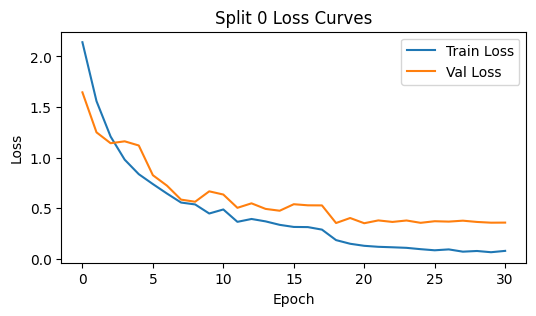

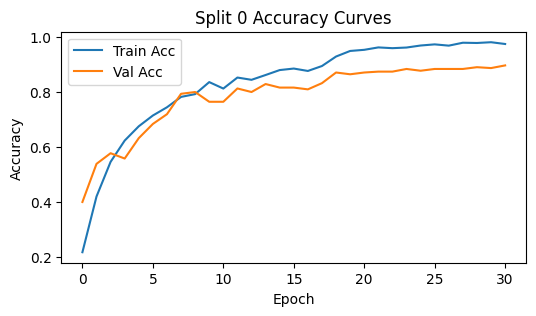

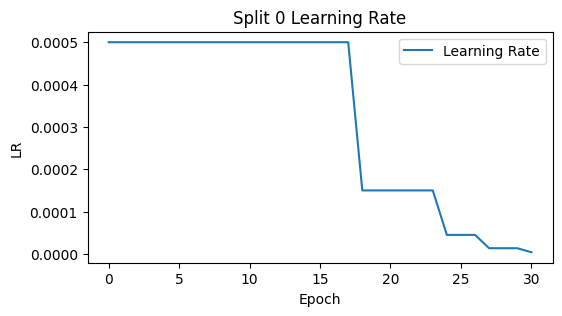

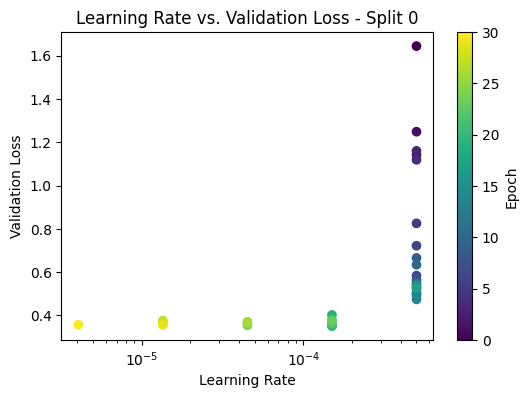

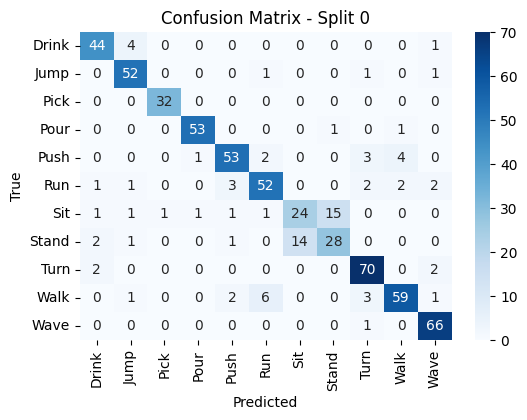

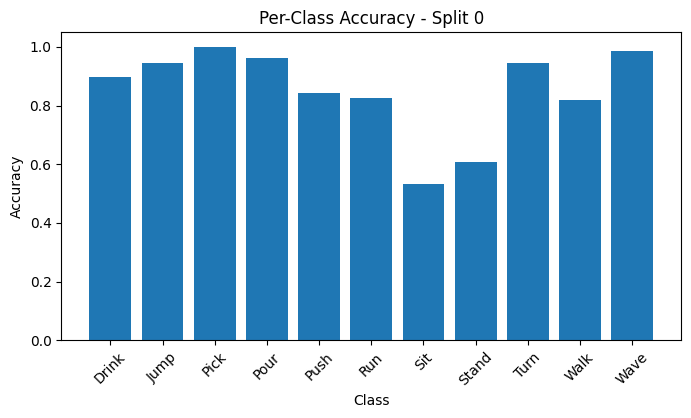

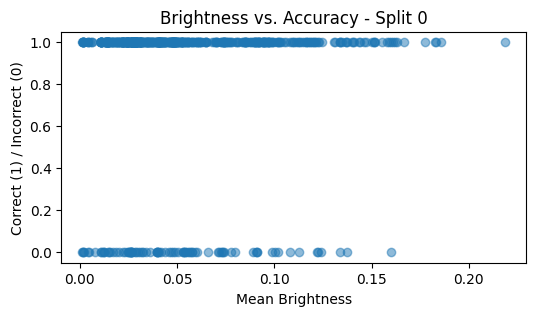

In [18]:
# -- Split 0 --

split_num = 0
train_size, val_size, test_size = create_splits(VIDEO_DIR, OUTPUT_DIR, split_num)

# Create datasets and loaders
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = create_datasets_and_loaders(split_num, VIDEO_DIR, OUTPUT_DIR)
class_names = sorted(train_dataset.label_to_idx.keys())

labels = [train_dataset[i][1] for i in range(len(train_dataset))]
class_counts = np.bincount(labels, minlength=NUM_CLASSES)
print("Class Counts:", class_counts)

# Initialize model and training components
model = DarkLiteFusion(num_classes=NUM_CLASSES, input_size=INPUT_SIZE).to(DEVICE)
class_weights = compute_class_weights(train_dataset, num_classes=NUM_CLASSES, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

# Train model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE, split_num)

# Load best model
model.load_state_dict(torch.load(f'best_model_split{split_num}.pth'))
model.eval()

# Evaluate test set
test_loss, top1_acc, top5_acc = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Top-1 Acc: {top1_acc:.4f}, Top-5 Acc: {top5_acc:.4f}")

# Evaluate dark robustness
brightness_acc = evaluate_dark_robustness(model, test_loader, DEVICE)

# Evaluate class-wise metrics
class_metrics = evaluate_class_metrics(model, test_loader, DEVICE, class_names, split_num)

# Evaluate noise robustness
noise_acc = evaluate_noise_robustness(model, test_loader, DEVICE, noise_std=0.1)

# Measure inference time
avg_time = measure_inference_time(model, test_loader, DEVICE)

# Compute model complexity
macs_str, params_str, flops_str = compute_model_complexity(model, split_num)

# Plot training curves
plot_loss_curves(history, split_num)
plot_accuracy_curves(history, split_num)
plot_lr_curve(history, split_num)

# Plot learning rate vs. loss
plot_lr_vs_loss(history, split_num)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, DEVICE, class_names, split_num)

# Plot per-class accuracy
plot_per_class_accuracy(model, test_loader, DEVICE, class_names, split_num)

# Plot brightness vs. accuracy
plot_brightness_vs_accuracy(model, test_loader, DEVICE, split_num)

Split 1 - Train: 2172, Val: 310, Test: 622
Created datasets for Split 1: Train=2172, Val=310, Test=622
Class Counts: [170 195 113 193 220 219 160 160 259 251 232]
Class Weights: [1.1614973545074463, 1.0125874280929565, 1.7473853826522827, 1.023080587387085, 0.8975206613540649, 0.9016189575195312, 1.2340909242630005, 1.2340909242630005, 0.7623727917671204, 0.78667151927948, 0.8510971665382385]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/40: Train Loss: 2.1477, Val Loss: 1.6764, Train Acc: 0.2385, Val Acc: 0.3645, LR: 0.000500
Epoch 2/40: Train Loss: 1.5332, Val Loss: 1.5510, Train Acc: 0.4300, Val Acc: 0.4290, LR: 0.000500
Epoch 3/40: Train Loss: 1.1599, Val Loss: 1.0849, Train Acc: 0.5543, Val Acc: 0.5871, LR: 0.000500
Epoch 4/40: Train Loss: 0.9736, Val Loss: 1.0243, Train Acc: 0.6229, Val Acc: 0.6129, LR: 0.000500
Epoch 5/40: Train Loss: 0.8020, Val Loss: 0.8546, Train Acc: 0.6888, Val Acc: 0.6452, LR: 0.000500
Epoch 6/40: Train Loss: 0.6920, Val Loss: 0.9274, Train Acc: 0.7242, Val Acc: 0.6290, LR: 0.000500
Epoch 7/40: Train Loss: 0.6422, Val Loss: 0.7514, Train Acc: 0.7505, Val Acc: 0.7097, LR: 0.000500
Epoch 8/40: Train Loss: 0.5735, Val Loss: 0.6338, Train Acc: 0.7919, Val Acc: 0.7742, LR: 0.000500
Epoch 9/40: Train Loss: 0.4696, Val Loss: 0.5667, Train Acc: 0.8204, Val Acc: 0.7677, LR: 0.000500
Epoch 10/40: Train Loss: 0.4743, Val Loss: 0.6754, Train Acc: 0.8112, Val Acc: 0.7452, LR: 0.000500
Epoch 11/

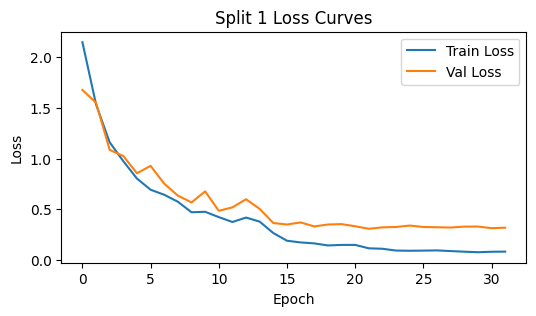

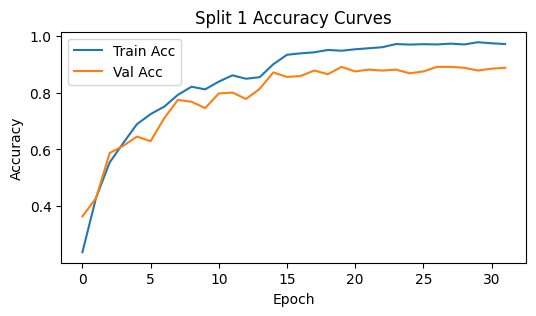

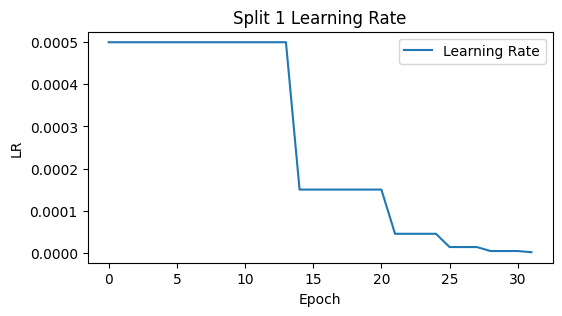

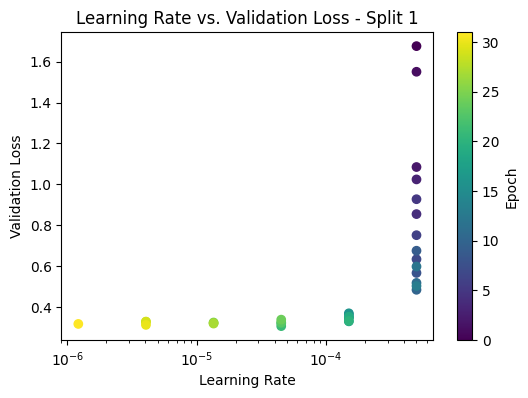

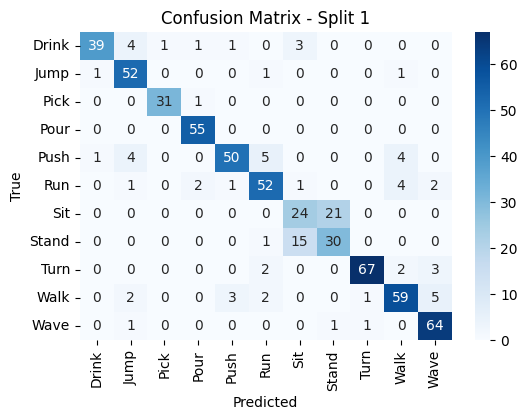

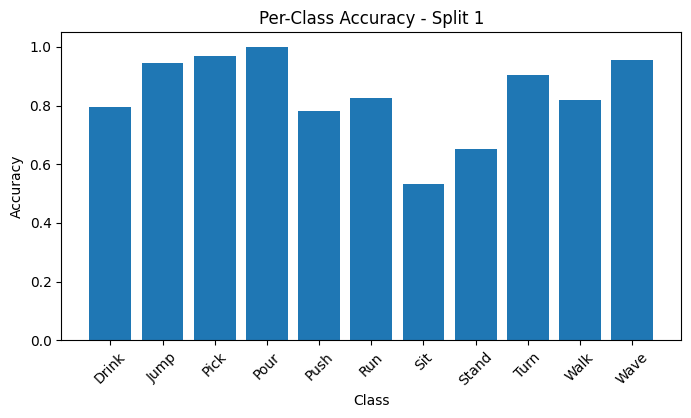

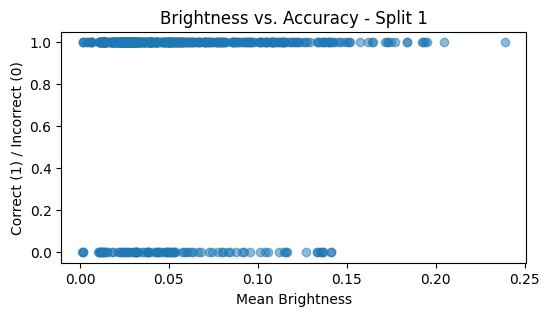

In [19]:
# -- Split 1 --

split_num = 1
train_size, val_size, test_size = create_splits(VIDEO_DIR, OUTPUT_DIR, split_num)

# Create datasets and loaders
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = create_datasets_and_loaders(split_num, VIDEO_DIR, OUTPUT_DIR)
class_names = sorted(train_dataset.label_to_idx.keys())

labels = [train_dataset[i][1] for i in range(len(train_dataset))]
class_counts = np.bincount(labels, minlength=NUM_CLASSES)
print("Class Counts:", class_counts)

# Initialize model and training components
model = DarkLiteFusion(num_classes=NUM_CLASSES, input_size=INPUT_SIZE).to(DEVICE)
class_weights = compute_class_weights(train_dataset, num_classes=NUM_CLASSES, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, verbose=True)

# Train model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE, split_num)

# Load best model
model.load_state_dict(torch.load(f'best_model_split{split_num}.pth'))
model.eval()

# Evaluate test set
test_loss, top1_acc, top5_acc = evaluate_model(model, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Top-1 Acc: {top1_acc:.4f}, Top-5 Acc: {top5_acc:.4f}")

# Evaluate dark robustness
brightness_acc = evaluate_dark_robustness(model, test_loader, DEVICE)

# Evaluate class-wise metrics
class_metrics = evaluate_class_metrics(model, test_loader, DEVICE, class_names, split_num)

# Evaluate noise robustness
noise_acc = evaluate_noise_robustness(model, test_loader, DEVICE, noise_std=0.1)

# Measure inference time
avg_time = measure_inference_time(model, test_loader, DEVICE)

# Compute model complexity
macs_str, params_str, flops_str = compute_model_complexity(model, split_num)

# Plot training curves
plot_loss_curves(history, split_num)
plot_accuracy_curves(history, split_num)
plot_lr_curve(history, split_num)

# Plot learning rate vs. loss
plot_lr_vs_loss(history, split_num)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, DEVICE, class_names, split_num)

# Plot per-class accuracy
plot_per_class_accuracy(model, test_loader, DEVICE, class_names, split_num)

# Plot brightness vs. accuracy
plot_brightness_vs_accuracy(model, test_loader, DEVICE, split_num)